## Utility functions and imports

In [5]:
import numpy as np
import cv2
import pywt
import matplotlib.pyplot as plt

import os
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from math import sqrt

def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0
  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  w = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(w,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels

def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / (np.sqrt(np.sum(np.multiply(X, X))) * np.sqrt(np.sum(np.multiply(X_star, X_star))))
    return s

def compute_thr(sim, mark, mark_size=1024, N=1000):
    SIM = np.zeros(N)
    for i in range(N):
        r = np.random.uniform(0.0, 1.0, mark_size)
        SIM[i] = (similarity(mark, r))
    SIMs = SIM.copy()
    SIM.sort()
    t = SIM[-1]
    T = t + (0.1*t)
    print('Threshold: ', T)
    return T, SIMs

In [6]:
#List of different attacks
from sklearn.metrics import roc_curve, auc

import random

#this seed was set just to make you obtain the same result
random.seed(3)
def awgn(img, std, seed):
  mean = 0.0   # some constant
  #np.random.seed(seed)
  attacked = img + np.random.normal(mean, std, img.shape)
  attacked = np.clip(attacked, 0, 255)
  return attacked

def blur(img, sigma):
  from scipy.ndimage.filters import gaussian_filter
  attacked = gaussian_filter(img, sigma)
  return attacked

def sharpening(img, sigma, alpha):
  import scipy
  from scipy.ndimage import gaussian_filter
  import matplotlib.pyplot as plt

  #print(img/255)
  filter_blurred_f = gaussian_filter(img, sigma)

  attacked = img + alpha * (img - filter_blurred_f)
  return attacked

def median(img, kernel_size):
  from scipy.signal import medfilt
  attacked = medfilt(img, kernel_size)
  return attacked

def resizing(img, scale):
  from skimage.transform import rescale
  x, y = img.shape
  attacked = rescale(img, scale)
  attacked = rescale(attacked, 1/scale)
  attacked = attacked[:x, :y]
  return attacked

def jpeg_compression(img, QF):
  from PIL import Image
  img = Image.fromarray(img)
  img.save('tmp.jpg',"JPEG", quality=QF)
  attacked = Image.open('tmp.jpg')
  attacked = np.asarray(attacked,dtype=np.uint8)
  os.remove('tmp.jpg')

  return attacked

## First technique (simpliest) function

In [50]:
def embedding1(image, mark, alpha=0.1, v='multiplicative'):

    # Generate a watermark
    # mark = np.random.uniform(0.0, 1.0, mark_size)
    # mark = np.uint8(np.rint(mark))
    # np.save('mark.npy', mark)

    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2

    coeffs3 = pywt.dwt2(LL, 'haar')
    LL2, (LH2, HL2, HH2) = coeffs3

    # Get the locations in LH
    sign_LH2 = np.sign(LH2)
    abs_LH2 = abs(LH2)
    locations_LH2 = np.argsort(-abs_LH2,axis=None) # - sign is used to get descending order
    rows_LH2 = LH2.shape[0]
    locations_LH2 = [(val//rows_LH2, val%rows_LH2) for val in locations_LH2] # locations as (x,y) coordinates

    # Get the locations in HL
    sign_HL2 = np.sign(HL2)
    abs_HL2 = abs(HL2)
    locations_HL2 = np.argsort(-abs_HL2,axis=None) # - sign is used to get descending order
    rows_HL2 = HL2.shape[0]
    locations_HL2 = [(val//rows_HL2, val%rows_HL2) for val in locations_HL2] # locations as (x,y) coordinates

    # Get the locations in HH
    sign_HH2 = np.sign(HH2)
    abs_HH2 = abs(HH2)
    locations_HH2 = np.argsort(-abs_HH2,axis=None) # - sign is used to get descending order
    rows_HH2 = HH2.shape[0]
    locations_HH2 = [(val//rows_HH2, val%rows_HH2) for val in locations_HH2] # locations as (x,y) coordinates
    # Embed the watermark in LH
    watermarked_LH2 = abs_LH2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH2[1:], mark)):
        if v == 'additive':
            watermarked_LH2[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_LH2[loc] *= 1 + ( alpha * mark_val)
    
     # Embed the watermark in LH
    watermarked_HL2 = abs_HL2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL2[1:], mark)):
        if v == 'additive':
            watermarked_HL2[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_HL2[loc] *= 1 + ( alpha * mark_val)
    
     # Embed the watermark in HH
    watermarked_HH2 = abs_HH2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH2[1:], mark)):
        if v == 'additive':
            watermarked_HH2[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_HH2[loc] *= 1 + ( alpha * mark_val)

    # Restore sign and o back to spatial domain
    watermarked_LH2 *= sign_LH2
    watermarked_HL2 *= sign_HL2
    watermarked_HH2 *= sign_HH2
    watermarked_LL = pywt.idwt2((LL2, (watermarked_LH2, watermarked_HL2, watermarked_HH2)), 'haar')
    watermarked = pywt.idwt2((watermarked_LL, (LH, HL, HH)), 'haar')

    return watermarked

def detection1(image, watermarked, alpha=0.5, mark_size=1024, v='multiplicative'):
    #ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs2 = pywt.dwt2(image, 'haar')
    LL_or, (LH_or, HL_or, HH_or) = coeffs2
    #wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs2 = pywt.dwt2(watermarked, 'haar')
    LL_w, (LH_w, HL_w, HH_w) = coeffs2

    #ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs3 = pywt.dwt2(LL_or, 'haar')
    LL2_or, (LH2_or, HL2_or, HH2_or) = coeffs3
    #wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs3 = pywt.dwt2(LL_w, 'haar')
    LL2_w, (LH2_w, HL2_w, HH2_w) = coeffs3

    # Get the locations in LH
    sign_LH2 = np.sign(LH2_or)
    abs_LH2 = abs(LH2_or)
    locations_LH2 = np.argsort(-abs_LH2,axis=None) # - sign is used to get descending order
    rows_LH2 = LH2_or.shape[0]
    locations_LH2 = [(val//rows_LH2, val%rows_LH2) for val in locations_LH2] # locations as (x,y) coordinates

    # Get the locations in HL
    sign_HL2 = np.sign(HL2_or)
    abs_HL2 = abs(HL2_or)
    locations_HL2 = np.argsort(-abs_HL2,axis=None) # - sign is used to get descending order
    rows_HL2 = HL2_or.shape[0]
    locations_HL2 = [(val//rows_HL2, val%rows_HL2) for val in locations_HL2] # locations as (x,y) coordinates

    # Get the locations in HH
    sign_HH2 = np.sign(HH2_or)
    abs_HH2 = abs(HH2_or)
    locations_HH2 = np.argsort(-abs_HH2,axis=None) # - sign is used to get descending order
    rows_HH2 = HH2_or.shape[0]
    locations_HH2 = [(val//rows_HH2, val%rows_HH2) for val in locations_HH2] # locations as (x,y) coordinates

    # Generate a watermark
    w_ex1 = np.zeros(mark_size, dtype=np.float64)
    w_ex2 = np.zeros(mark_size, dtype=np.float64)
    w_ex3 = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations_LH2[1:mark_size+1]):
        if v=='additive':
            w_ex1[idx] =  (LH2_w[loc] - LH2_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex1[idx] =  (LH2_w[loc] - LH2_or[loc]) / (alpha*LH2_or[loc])
    
     # Embed the watermark
    for idx, loc in enumerate(locations_HL2[1:mark_size+1]):
        if v=='additive':
            w_ex2[idx] =  (HL2_w[loc] - HL2_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex2[idx] =  (HL2_w[loc] - HL2_or[loc]) / (alpha*HL2_or[loc])

     # Embed the watermark
    for idx, loc in enumerate(locations_HH2[1:mark_size+1]):
        if v=='additive':
            w_ex3[idx] =  (HH2_w[loc] - HH2_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex3[idx] =  (HH2_w[loc] - HH2_or[loc]) / (alpha*HH2_or[loc])
    
    w_ex = (w_ex1 + w_ex2 + w_ex3)/3
    return w_ex


In [52]:
imgs = [cv2.imread(os.path.join('./sample_imgs', img), 0) for img in os.listdir('./sample_imgs')]
N = 1024
mark = np.load('ammhackati.npy')

In [57]:
alpha = 0.5

v = 'multiplicative'
np.random.seed(seed=123)

wm_imgs = []
wpsnr_wm_imgs = []

for img in imgs:
    wm = embedding1(img, mark, alpha)
    wm_imgs.append(wm)
    wpsnr_wm_imgs.append(wpsnr(img, wm))

In [ ]:
lost = 0
for org_img, wm_img, quality in zip(imgs, wm_imgs, wpsnr_wm_imgs):
    w_ex = detection1(org_img, wm_img, alpha)
    attacked_wimg = awgn(wm_img, 24, np.random.seed(123))
    w_ex_attacked = detection1(org_img, attacked_wimg, alpha)

    print("WPSNR watermarked img before being attacked: ", quality);
    print("WPSNR watermarked img after being attackted: ", wpsnr(attacked_wimg, wm_img))

    sim_not_attacked = similarity(mark, w_ex)
    sim_attacked = similarity(w_ex, w_ex_attacked)

    t, _ = compute_thr(sim_not_attacked, mark)

    print('\n')
    if sim_not_attacked > t:
        print('Mark has been found in the non-attacked image. SIM = %f' % sim_not_attacked)
    else:
        print('Mark has been lost in the non-attacked image. SIM = %f' % sim_not_attacked)
    if sim_attacked > t or wpsnr(attacked_wimg, wm_img) < 35.0:
        print('Mark has been found in the attacked image. SIM = %f' % sim_attacked)
    else:
        lost += 1

        print('Mark has been lost in the attacked image. SIM = %f' % sim_attacked)
    print('--------------------------')
    print('\n')


p = (lost/len(imgs)) * 100
print("Watermark lost in %2f of the images" % p);
print(f"Watermark has been lost in {lost}/{len(imgs)} images")

## Second technique

In [2]:
def embedding2(image, mark, alphaOne=0.5, alphaTwo=0.5, v='multiplicative'):

    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2
    coeffs3 = pywt.dwt2(LL, 'haar')
    LL2, (LH2, HL2, HH2) = coeffs3

    # Get the locations in LLLH
    sign_LH2 = np.sign(LH2)
    abs_LH2 = abs(LH2)
    locations_LH2 = np.argsort(-abs_LH2,axis=None) # - sign is used to get descending order
    rows_LH2 = LH2.shape[0]
    locations_LH2 = [(val//rows_LH2, val%rows_LH2) for val in locations_LH2] # locations as (x,y) coordinates

    # Get the locations in LLHL
    sign_HL2 = np.sign(HL2)
    abs_HL2 = abs(HL2)
    locations_HL2 = np.argsort(-abs_HL2,axis=None) # - sign is used to get descending order
    rows_HL2 = HL2.shape[0]
    locations_HL2 = [(val//rows_HL2, val%rows_HL2) for val in locations_HL2] # locations as (x,y) coordinates

    # Get the locations in LLHH
    sign_HH2 = np.sign(HH2)
    abs_HH2 = abs(HH2)
    locations_HH2 = np.argsort(-abs_HH2,axis=None) # - sign is used to get descending order
    rows_HH2 = HH2.shape[0]
    locations_HH2 = [(val//rows_HH2, val%rows_HH2) for val in locations_HH2] # locations as (x,y) coordinates
    
    # Embed the watermark in LLLH
    watermarked_LH2 = abs_LH2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH2[1:], mark)):
        if v == 'additive':
            watermarked_LH2[loc] += (alphaOne * mark_val)
        elif v == 'multiplicative':
            watermarked_LH2[loc] *= 1 + (alphaOne * mark_val)
    
     # Embed the watermark in LLHL
    watermarked_HL2 = abs_HL2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL2[1:], mark)):
        if v == 'additive':
            watermarked_HL2[loc] += (alphaOne * mark_val)
        elif v == 'multiplicative':
            watermarked_HL2[loc] *= 1 + (alphaOne * mark_val)
    
     # Embed the watermark in LLHH
    watermarked_HH2 = abs_HH2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH2[1:], mark)):
        if v == 'additive':
            watermarked_HH2[loc] += (alphaOne * mark_val)
        elif v == 'multiplicative':
            watermarked_HH2[loc] *= 1 + (alphaOne * mark_val)

    # Restore sign and o back to spatial domain
    watermarked_LH2 *= sign_LH2
    watermarked_HL2 *= sign_HL2
    watermarked_HH2 *= sign_HH2
    watermarked_LL = pywt.idwt2((LL2, (watermarked_LH2, watermarked_HL2, watermarked_HH2)), 'haar')

    # Get the locations in LH
    sign_LH = np.sign(LH)
    abs_LH = abs(LH)
    locations_LH = np.argsort(-abs_LH,axis=None) # - sign is used to get descending order
    rows_LH = LH.shape[0]
    locations_LH = [(val//rows_LH, val%rows_LH) for val in locations_LH] # locations as (x,y) coordinates

    # Get the locations in HL
    sign_HL = np.sign(HL)
    abs_HL = abs(HL)
    locations_HL = np.argsort(-abs_HL,axis=None) # - sign is used to get descending order
    rows_HL = HL.shape[0]
    locations_HL = [(val//rows_HL, val%rows_HL) for val in locations_HL] # locations as (x,y) coordinates

    # Get the locations in HH
    sign_HH = np.sign(HH)
    abs_HH = abs(HH)
    locations_HH = np.argsort(-abs_HH,axis=None) # - sign is used to get descending order
    rows_HH = HH.shape[0]
    locations_HH = [(val//rows_HH, val%rows_HH) for val in locations_HH] # locations as (x,y) coordinates

    # Embed the watermark in LH
    watermarked_LH = abs_LH.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH[1:], mark)):
        if v == 'additive':
            watermarked_LH[loc] += (alphaTwo * mark_val)
        elif v == 'multiplicative':
            watermarked_LH[loc] *= 1 + ( alphaTwo * mark_val)
    
     # Embed the watermark in LH
    watermarked_HL = abs_HL.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL[1:], mark)):
        if v == 'additive':
            watermarked_HL[loc] += (alphaTwo * mark_val)
        elif v == 'multiplicative':
            watermarked_HL[loc] *= 1 + ( alphaTwo * mark_val)
    
     # Embed the watermark in HH
    watermarked_HH = abs_HH.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH[1:], mark)):
        if v == 'additive':
            watermarked_HH[loc] += (alphaTwo * mark_val)
        elif v == 'multiplicative':
            watermarked_HH[loc] *= 1 + ( alphaTwo * mark_val)

    # Restore sign and o back to spatial domain
    watermarked_LH *= sign_LH
    watermarked_HL *= sign_HL
    watermarked_HH *= sign_HH
    watermarked = pywt.idwt2((watermarked_LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')

    return watermarked

def detection2(image, watermarked, alphaOne, alphaTwo, mark_size=1024, v='multiplicative'):
    #ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs2 = pywt.dwt2(image, 'haar')
    LL_or, (LH_or, HL_or, HH_or) = coeffs2
    coeffs3 = pywt.dwt2(LL_or, 'haar')
    LL2_or, (LH2_or, HL2_or, HH2_or) = coeffs3

    #wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs4 = pywt.dwt2(watermarked, 'haar')
    LL_w, (LH_w, HL_w, HH_w) = coeffs4
    coeffs5 = pywt.dwt2(LL_w, 'haar')
    LL2_w, (LH2_w, HL2_w, HH2_w) = coeffs5

    # Get the locations in LH2
    sign_LH2 = np.sign(LH2_or)
    abs_LH2 = abs(LH2_or)
    locations_LH2 = np.argsort(-abs_LH2,axis=None) # - sign is used to get descending order
    rows_LH2 = LH2_or.shape[0]
    locations_LH2 = [(val//rows_LH2, val%rows_LH2) for val in locations_LH2] # locations as (x,y) coordinates

    # Get the locations in HL2
    sign_HL2 = np.sign(HL2_or)
    abs_HL2 = abs(HL2_or)
    locations_HL2 = np.argsort(-abs_HL2,axis=None) # - sign is used to get descending order
    rows_HL2 = HL2_or.shape[0]
    locations_HL2 = [(val//rows_HL2, val%rows_HL2) for val in locations_HL2] # locations as (x,y) coordinates

    # Get the locations in HH2
    sign_HH2 = np.sign(HH2_or)
    abs_HH2 = abs(HH2_or)
    locations_HH2 = np.argsort(-abs_HH2,axis=None) # - sign is used to get descending order
    rows_HH2 = HH2_or.shape[0]
    locations_HH2 = [(val//rows_HH2, val%rows_HH2) for val in locations_HH2] # locations as (x,y) coordinates

    # Generate a watermark
    w_ex1 = np.zeros(mark_size, dtype=np.float64)
    w_ex2 = np.zeros(mark_size, dtype=np.float64)
    w_ex3 = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations_LH2[1:mark_size+1]):
        if v=='additive':
            w_ex1[idx] =  (LH2_w[loc] - LH2_or[loc]) /alphaOne
        elif v=='multiplicative':
            w_ex1[idx] =  (LH2_w[loc] - LH2_or[loc]) / (alphaOne*LH2_or[loc])
    
    # Embed the watermark
    for idx, loc in enumerate(locations_HL2[1:mark_size+1]):
        if v=='additive':
            w_ex2[idx] =  (HL2_w[loc] - HL2_or[loc]) /alphaOne
        elif v=='multiplicative':
            w_ex2[idx] =  (HL2_w[loc] - HL2_or[loc]) / (alphaOne*HL2_or[loc])

    # Embed the watermark
    for idx, loc in enumerate(locations_HH2[1:mark_size+1]):
        if v=='additive':
            w_ex3[idx] =  (HH2_w[loc] - HH2_or[loc]) /alphaOne
        elif v=='multiplicative':
            w_ex3[idx] =  (HH2_w[loc] - HH2_or[loc]) / (alphaOne*HH2_or[loc])

    w_exOne = (w_ex1 + w_ex2 + w_ex3) / 3

    # Get the locations in LH
    sign_LH = np.sign(LH_or)
    abs_LH = abs(LH_or)
    locations_LH = np.argsort(-abs_LH,axis=None) # - sign is used to get descending order
    rows_LH = LH_or.shape[0]
    locations_LH = [(val//rows_LH, val%rows_LH) for val in locations_LH] # locations as (x,y) coordinates


    # Get the locations in HL
    sign_HL = np.sign(HL_or)
    abs_HL = abs(HL_or)
    locations_HL = np.argsort(-abs_HL,axis=None) # - sign is used to get descending order
    rows_HL = HL_or.shape[0]
    locations_HL = [(val//rows_HL, val%rows_HL) for val in locations_HL] # locations as (x,y) coordinates

    # Get the locations in HH
    sign_HH = np.sign(HH_or)
    abs_HH = abs(HH_or)
    locations_HH = np.argsort(-abs_HH,axis=None) # - sign is used to get descending order
    rows_HH = HH_or.shape[0]
    locations_HH = [(val//rows_HH, val%rows_HH) for val in locations_HH] # locations as (x,y) coordinates

    # Generate a watermark
    w_ex1 = np.zeros(mark_size, dtype=np.float64)
    w_ex2 = np.zeros(mark_size, dtype=np.float64)
    w_ex3 = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations_LH[1:mark_size+1]):
        if v=='additive':
            w_ex1[idx] =  (LH_w[loc] - LH_or[loc]) /alphaTwo
        elif v=='multiplicative':
            w_ex1[idx] =  (LH_w[loc] - LH_or[loc]) / (alphaTwo*LH_or[loc])
    
     # Embed the watermark
    for idx, loc in enumerate(locations_HL[1:mark_size+1]):
        if v=='additive':
            w_ex2[idx] =  (HL_w[loc] - HL_or[loc]) /alphaTwo
        elif v=='multiplicative':
            w_ex2[idx] =  (HL_w[loc] - HL_or[loc]) / (alphaTwo*HL_or[loc])

     # Embed the watermark
    for idx, loc in enumerate(locations_HH[1:mark_size+1]):
        if v=='additive':
            w_ex3[idx] =  (HH_w[loc] - HH_or[loc]) /alphaTwo
        elif v=='multiplicative':
            w_ex3[idx] =  (HH_w[loc] - HH_or[loc]) / (alphaTwo*HH_or[loc])
    
    w_exTwo = (w_ex1 + w_ex2 + w_ex3) / 3


    return [w_exOne, w_exTwo]

In [45]:
alphaOne = 0.5
alphaTwo = 0.2

v = 'multiplicative'
np.random.seed(seed=123)

wm_imgs = []
wpsnr_wm_imgs = []

for img in imgs:
    wm = embedding2(img, mark, alphaOne=alphaOne, alphaTwo=alphaTwo)
    wm_imgs.append(wm)
    wpsnr_wm_imgs.append(wpsnr(img, wm))
    

In [ ]:
attacked = awgn(wm_imgs[0], 10, 123)

plt.subplot(131)
plt.title('Original')
plt.imshow(imgs[0], cmap='gray')
plt.subplot(132)
plt.title('Watermarked')
plt.imshow(wm_imgs[0], cmap='gray')
plt.subplot(133)
plt.title('Attacked Watermarked')
plt.imshow(attacked,cmap='gray')

In [ ]:
lost = 0
for org_img, wm_img, quality in zip(imgs, wm_imgs, wpsnr_wm_imgs):
    w_ex = detection2(org_img, wm_img, alphaOne=alphaOne, alphaTwo=alphaTwo)
    attacked_wimg = awgn(wm_img, 24, np.random.seed(123))
    w_ex_attacked = detection2(org_img, attacked_wimg, alphaOne=alphaOne, alphaTwo=alphaTwo)

    print("WPSNR watermarked img before being attacked: ", quality);
    print("WPSNR watermarked img after being attackted: ", wpsnr(attacked_wimg, org_img))

    
    sim_not_attacked = max(similarity(mark, w_ex[0]), similarity(mark, w_ex[1]))
    sim_attacked = max(similarity(w_ex[0], w_ex_attacked[0]), similarity(w_ex[1], w_ex_attacked[1]))
    
    t, _ = compute_thr(sim_not_attacked, mark)

    print('\n')
    if sim_not_attacked > t:
        print('Mark has been found in the non-attacked image. SIM = %f' % sim_not_attacked)
    else:
        print('Mark has been lost in the non-attacked image. SIM = %f' % sim_not_attacked)
    if sim_attacked > t:
        print('Mark has been found in the attacked image. SIM = %f' % sim_attacked)
    else:
        lost += 1
        print('Mark has been lost in the attacked image. SIM = %f' % sim_attacked)
    print('--------------------------')
    print('\n')


p = (lost/len(imgs)) * 100
print("Watermark lost in %2f of the images" % p);
print(f"Watermark has been lost in {lost}/{len(imgs)} images")

In [ ]:
print(wpsnr_wm_imgs[0])

## Third technique

In [ ]:
def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0
  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  w = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(w,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels

def modularAlpha(layer, theta, alpha):
    arrayLayer = [1.0, 0.32, 0.16, 0.1]
    arrayTheta = [1, sqrt(2), 1]

    return alpha * arrayLayer[layer] * arrayTheta[theta]

def embedding(image, mark, alpha, v='multiplicative'):


    coeffs2 = pywt.dwt2(image, 'haar')
    LL0, (LH0, HL0, HH0) = coeffs2

    coeffs3 = pywt.dwt2(LL0, 'haar')
    LL1, (LH1, HL1, HH1) = coeffs3

    coeffs4 = pywt.dwt2(LL1, 'haar')
    LL2, (LH2, HL2, HH2) = coeffs4

    coeffs5 = pywt.dwt2(LL2, 'haar')
    LL3, (LH3, HL3, HH3) = coeffs5

    # Get the locations in LH0
    sign_LH0 = np.sign(LH0)
    abs_LH0 = abs(LH0)
    locations_LH0 = np.argsort(-abs_LH0,axis=None) # - sign is used to get descending order
    rows_LH0 = LH0.shape[0]
    locations_LH0 = [(val//rows_LH0, val%rows_LH0) for val in locations_LH0] # locations as (x,y) coordinates

    # Get the locations in HL0
    sign_HL0 = np.sign(HL0)
    abs_HL0 = abs(HL0)
    locations_HL0 = np.argsort(-abs_HL0,axis=None) # - sign is used to get descending order
    rows_HL0 = HL0.shape[0]
    locations_HL0 = [(val//rows_HL0, val%rows_HL0) for val in locations_HL0] # locations as (x,y) coordinates

    # Get the locations in HH0
    sign_HH0 = np.sign(HH0)
    abs_HH0 = abs(HH0)
    locations_HH0 = np.argsort(-abs_HH0,axis=None) # - sign is used to get descending order
    rows_HH0 = HH0.shape[0]
    locations_HH0 = [(val//rows_HH0, val%rows_HH0) for val in locations_HH0] # locations as (x,y) coordinates
    
    # Embed the watermark in LH0
    watermarked_LH0 = abs_LH0.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH0[1:], mark)):
        if v == 'additive':
            layer = 0
            theta = 0
            watermarked_LH0[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 0
            theta = 0
            watermarked_LH0[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)
    
     # Embed the watermark in LH0
    watermarked_HL0 = abs_HL0.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL0[1:], mark)):
        if v == 'additive':
            layer = 0
            theta = 2
            watermarked_HL0[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 0
            theta = 2
            watermarked_HL0[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)
    
     # Embed the watermark in HH0
    watermarked_HH0 = abs_HH0.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH0[1:], mark)):
        if v == 'additive':
            layer = 0
            theta = 1
            watermarked_HH0[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 0
            theta = 1
            watermarked_HH0[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)

    # Get the locations in LH1
    sign_LH1 = np.sign(LH1)
    abs_LH1 = abs(LH1)
    locations_LH1 = np.argsort(-abs_LH1,axis=None) # - sign is used to get descending order
    rows_LH1 = LH1.shape[0]
    locations_LH1 = [(val//rows_LH1, val%rows_LH1) for val in locations_LH1] # locations as (x,y) coordinates

    # Get the locations in HL1
    sign_HL1 = np.sign(HL1)
    abs_HL1 = abs(HL1)
    locations_HL1 = np.argsort(-abs_HL1,axis=None) # - sign is used to get descending order
    rows_HL1 = HL1.shape[0]
    locations_HL1 = [(val//rows_HL1, val%rows_HL1) for val in locations_HL1] # locations as (x,y) coordinates

    # Get the locations in HH1
    sign_HH1 = np.sign(HH1)
    abs_HH1 = abs(HH1)
    locations_HH1 = np.argsort(-abs_HH1,axis=None) # - sign is used to get descending order
    rows_HH1 = HH1.shape[0]
    locations_HH1 = [(val//rows_HH1, val%rows_HH1) for val in locations_HH1] # locations as (x,y) coordinates
    
    # Embed the watermark in LH1
    watermarked_LH1 = abs_LH1.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH1[1:], mark)):
        if v == 'additive':
            layer = 1
            theta = 0
            watermarked_LH1[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 1
            theta = 0
            watermarked_LH1[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)
    
     # Embed the watermark in LH1
    watermarked_HL1 = abs_HL1.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL1[1:], mark)):
        if v == 'additive':
            layer = 1
            theta = 2
            watermarked_HL1[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 1
            theta = 2
            watermarked_HL1[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)
    
     # Embed the watermark in HH1
    watermarked_HH1 = abs_HH1.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH1[1:], mark)):
        if v == 'additive':
            layer = 1
            theta = 1
            watermarked_HH1[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 1
            theta = 1
            watermarked_HH1[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)

# Get the locations in LH2
    sign_LH2 = np.sign(LH2)
    abs_LH2 = abs(LH2)
    locations_LH2 = np.argsort(-abs_LH2,axis=None) # - sign is used to get descending order
    rows_LH2 = LH2.shape[0]
    locations_LH2 = [(val//rows_LH2, val%rows_LH2) for val in locations_LH2] # locations as (x,y) coordinates

    # Get the locations in HL2
    sign_HL2 = np.sign(HL2)
    abs_HL2 = abs(HL2)
    locations_HL2 = np.argsort(-abs_HL2,axis=None) # - sign is used to get descending order
    rows_HL2 = HL2.shape[0]
    locations_HL2 = [(val//rows_HL2, val%rows_HL2) for val in locations_HL2] # locations as (x,y) coordinates

    # Get the locations in HH2
    sign_HH2 = np.sign(HH2)
    abs_HH2 = abs(HH2)
    locations_HH2 = np.argsort(-abs_HH2,axis=None) # - sign is used to get descending order
    rows_HH2 = HH2.shape[0]
    locations_HH2 = [(val//rows_HH2, val%rows_HH2) for val in locations_HH2] # locations as (x,y) coordinates

    # Embed the watermark in LH2
    watermarked_LH2 = abs_LH2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH2[1:], mark)):
        if v == 'additive':
            layer = 2
            theta = 0
            watermarked_LH2[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 2
            theta = 0
            watermarked_LH2[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)
    
     # Embed the watermark in LH2
    watermarked_HL2 = abs_HL2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL2[1:], mark)):
        if v == 'additive':
            layer = 2
            theta = 2
            watermarked_HL2[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 2
            theta = 2
            watermarked_HL2[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)
    
     # Embed the watermark in HH2
    watermarked_HH2 = abs_HH2.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH2[1:], mark)):
        if v == 'additive':
            layer = 2
            theta = 1
            watermarked_HH2[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 2
            theta = 1
            watermarked_HH2[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)

    # Get the locations in LH3
    sign_LH3 = np.sign(LH3)
    abs_LH3 = abs(LH3)
    locations_LH3 = np.argsort(-abs_LH3,axis=None) # - sign is used to get descending order
    rows_LH3 = LH3.shape[0]
    locations_LH3 = [(val//rows_LH3, val%rows_LH3) for val in locations_LH3] # locations as (x,y) coordinates

    # Get the locations in HL3
    sign_HL3 = np.sign(HL3)
    abs_HL3 = abs(HL3)
    locations_HL3 = np.argsort(-abs_HL3,axis=None) # - sign is used to get descending order
    rows_HL3 = HL3.shape[0]
    locations_HL3 = [(val//rows_HL3, val%rows_HL3) for val in locations_HL3] # locations as (x,y) coordinates

    # Get the locations in HH3
    sign_HH3 = np.sign(HH3)
    abs_HH3 = abs(HH3)
    locations_HH3 = np.argsort(-abs_HH3,axis=None) # - sign is used to get descending order
    rows_HH3 = HH3.shape[0]
    locations_HH3 = [(val//rows_HH3, val%rows_HH3) for val in locations_HH3] # locations as (x,y) coordinates

    # Embed the watermark in LH3
    watermarked_LH3 = abs_LH3.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH3[1:], mark)):
        if v == 'additive':
            layer = 3
            theta = 0
            watermarked_LH3[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 3
            theta = 0
            watermarked_LH3[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)
    
     # Embed the watermark in LH3
    watermarked_HL3 = abs_HL3.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL3[1:], mark)):
        if v == 'additive':
            layer = 3
            theta = 2
            watermarked_HL3[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 3
            theta = 2
            watermarked_HL3[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)
    
     # Embed the watermark in HH3
    watermarked_HH3 = abs_HH3.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH3[1:], mark)):
        if v == 'additive':
            layer = 3
            theta = 1
            watermarked_HH3[loc] += (modularAlpha(layer, theta, alpha) * mark_val)
        elif v == 'multiplicative':
            layer = 3
            theta = 1
            watermarked_HH3[loc] *= 1 + (modularAlpha(layer, theta, alpha) * mark_val)
    
    # Restore sign and o back to spatial domain
    watermarked_LH3 *= sign_LH3
    watermarked_HL3 *= sign_HL3
    watermarked_HH3 *= sign_HH3
    watermarked_LL2 = pywt.idwt2((LL3, (watermarked_LH3, watermarked_HL3, watermarked_HH3)), 'haar')

    watermarked_LH2 *= sign_LH2
    watermarked_HL2 *= sign_HL2
    watermarked_HH2 *= sign_HH2
    watermarked_LL1 = pywt.idwt2((watermarked_LL2, (watermarked_LH2, watermarked_HL2, watermarked_HH2)), 'haar')

    watermarked_LH1 *= sign_LH1
    watermarked_HL1 *= sign_HL1
    watermarked_HH1 *= sign_HH1
    watermarked_LL0 = pywt.idwt2((watermarked_LL1, (watermarked_LH1, watermarked_HL1, watermarked_HH1)), 'haar')

    watermarked_LH0 *= sign_LH0
    watermarked_HL0 *= sign_HL0
    watermarked_HH0 *= sign_HH0
    watermarked = pywt.idwt2((watermarked_LL0, (watermarked_LH0, watermarked_HL0, watermarked_HH0)), 'haar')

    return watermarked

img_path='lena_grey.bmp'
alpha = 0.8
v = 'multiplicative'

imgs = [cv2.imread(os.path.join('./sample_imgs', img), 0) for img in os.listdir('./sample_imgs')]
mark = np.load('ammhackati.npy')

wm_imgs = []
wpsnr_wm_imgs = []

for img in imgs:
    wm = embedding(img, mark, alpha)
    wm_imgs.append(wm)
    wpsnr_wm_imgs.append(wpsnr(img, wm))
 
# watermarkedPicture = embedding(image, mark, alpha, v='multiplicative')
# wspnr_watermarked = wpsnr(image, watermarkedPicture)

# plt.subplot(121)
# plt.title('Original')
# plt.imshow(image, cmap='gray')
# plt.subplot(122)
# plt.title('Watermarked')
# plt.imshow(watermarkedPicture, cmap='gray')

for score in wpsnr_wm_imgs:
    print('WPSNR non-ATTACKED IMAGE = ', score)

print("mean wpsnr: ", np.mean(wpsnr_wm_imgs))


## Fourth technique

1023


ValueError: operands could not be broadcast together with shapes (1024,) (1023,) 

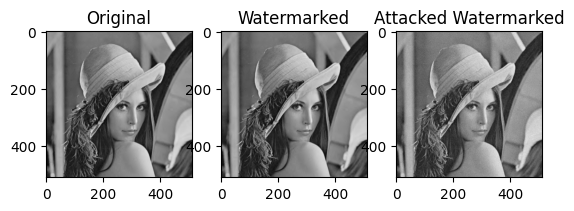

In [21]:
def create_perceptual_mask(subband):

    mask = np.ones(subband.shape)
    mask *= compute_brightness_sensitivity(subband) * compute_edge_sensitivity(subband) * compute_texture_sensitivity(subband)
    
    return mask

def compute_brightness_sensitivity(subband):

    # Normalize brightness between 0 and 1
    min_brightness = np.min(subband)
    max_brightness = np.max(subband)
    brightness_sensitivity = (subband - min_brightness) / (max_brightness - min_brightness + 1e-6)
    
    # Invert to give higher sensitivity in dark areas (lower brightness = higher mask value)
    return 1 - brightness_sensitivity

def compute_edge_sensitivity(subband):

    # Compute image gradient (strong edges correspond to higher gradients)
    sobel_x = cv2.Sobel(subband, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(subband, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # Normalize gradient magnitude between 0 and 1
    gradient_sensitivity = (gradient_magnitude - np.min(gradient_magnitude)) / (np.max(gradient_magnitude) - np.min(gradient_magnitude) + 1e-6)
    
    return gradient_sensitivity

def compute_texture_sensitivity(subband):
    
    # Compute local variance as a measure of texture
    mean = cv2.blur(subband, (3, 3))
    local_variance = cv2.blur((subband - mean) ** 2, (3, 3))
    
    # Normalize local variance between 0 and 1
    texture_sensitivity = (local_variance - np.min(local_variance)) / (np.max(local_variance) - np.min(local_variance) + 1e-6)
    
    return texture_sensitivity

def modular_alpha(layer, theta, alpha):
    arrayLayer = [1.0, 0.32, 0.16, 0.1]
    arrayTheta = [1, sqrt(2), 1]

    return alpha * arrayLayer[layer] * arrayTheta[theta]

def get_locations(subband):
    sign = np.sign(subband)
    abs_subband = abs(subband)
    locations = np.argsort(-abs_subband, axis=None) # - sign is used to get descending order
    rows = subband.shape[0]
    locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

    return abs_subband, sign, locations

def embed_watermark(subband, mark, layer, theta, alpha=0.5, v='multiplicative'):

    mask = create_perceptual_mask(subband)
    abs_subband, sign, locations = get_locations(subband) 

    watermarked = abs_subband.copy()
    for idx, (loc, mark_val) in enumerate(zip(locations[1:], mark)):
        x = locations[idx][0]
        y = locations[idx][1]
        if v == 'additive':
            watermarked[loc] += (modular_alpha(layer, theta, alpha) * mark_val * mask[x][y])
        elif v == 'multiplicative':
            watermarked[loc] *= 1 + (modular_alpha(layer, theta, alpha) * mark_val * mask[x][y])
    
    return sign * watermarked

def recursive_embedding(coeffs, mark, alpha, layer, max_layer, v='multiplicative'):
    LL, (LH, HL, HH) = coeffs

    # Base case: if we reach layer 3, embed the watermark and return
    if layer == max_layer:
        watermarked_LH = embed_watermark(LH, mark, layer, 0, alpha, v)
        watermarked_HL = embed_watermark(HL, mark, layer, 2, alpha, v)
        watermarked_HH = embed_watermark(HH, mark, layer, 1, alpha, v)

        watermarked_LL = pywt.idwt2((LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')
        return watermarked_LL

    # Recursive case: perform another DWT and recurse
    coeffs_next = pywt.dwt2(LL, 'haar')
    watermarked_LL = recursive_embedding(coeffs_next, mark, alpha, layer + 1, max_layer, v)

    # Embed the watermark at this layer
    watermarked_LH = embed_watermark(LH, mark, layer, 0, alpha, v)
    watermarked_HL = embed_watermark(HL, mark, layer, 2, alpha, v)
    watermarked_HH = embed_watermark(HH, mark, layer, 1, alpha, v)

    # Return the inverse DWT of the watermarked image
    watermarked = pywt.idwt2((watermarked_LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')
    return watermarked


def embedding(image, mark, alpha, max_layer=3, v='multiplicative'):
    # Initial wavelet decomposition
    coeffs = pywt.dwt2(image, 'haar')
    
    # Start recursive embedding from layer 0
    watermarked_image = recursive_embedding(coeffs, mark, alpha, layer=0, max_layer=max_layer, v=v)
    
    return watermarked_image


def extract_watermark(subband, watermarked_subband, layer, theta, alpha=0.5, v='multiplicative'):
    # Create perceptual mask for the subband
    mask = create_perceptual_mask(subband)
    abs_subband, sign, locations = get_locations(subband)
    abs_watermarked, _, _ = get_locations(watermarked_subband)
    mark_size = 1024

    extracted_mark = []
    
    # Loop through each location (except the first one)
    for idx, loc in enumerate(locations[1:mark_size+1]):
        x = locations[idx][0]
        y = locations[idx][1]
        
        if v == 'additive':
            # Reverse the additive watermarking process to extract the mark
            extracted_value = (abs_watermarked[loc] - abs_subband[loc]) / (modular_alpha(layer, theta, alpha) * mask[x][y] + 1e-6)
        elif v == 'multiplicative':
            # Reverse the multiplicative watermarking process to extract the mark
            extracted_value = ((abs_watermarked[loc] / abs_subband[loc]) - 1 + 1e-6) / (modular_alpha(layer, theta, alpha) * mask[x][y] + 1e-6)
        
        # Append the extracted mark value
        extracted_mark.append(extracted_value)
    
    return np.array(extracted_mark)



def detection(image, watermarked, alpha, max_layer=3, v='multiplicative'):
    #ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    LL0_or, (LH0_or, HL0_or, HH0_or) = pywt.dwt2(image, 'haar')
    LL1_or, (LH1_or, HL1_or, HH1_or) = pywt.dwt2(LL0_or, 'haar')
    LL2_or, (LH2_or, HL2_or, HH2_or) = pywt.dwt2(LL1_or, 'haar')
    LL3_or, (LH3_or, HL3_or, HH3_or) = pywt.dwt2(LL2_or, 'haar')
     

    #wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')
    LL0_w, (LH0_w, HL0_w, HH0_w) = pywt.dwt2(watermarked, 'haar')
    LL1_w, (LH1_w, HL1_w, HH1_w) = pywt.dwt2(LL0_w, 'haar')
    LL2_w, (LH2_w, HL2_w, HH2_w) = pywt.dwt2(LL1_w, 'haar')
    LL3_w, (LH3_w, HL3_w, HH3_w) = pywt.dwt2(LL2_w, 'haar')
    
    extracted_wms = []
    extracted_wms.append(extract_watermark(LH3_or, LH3_w, 3, 0, alpha=alpha, v=v))
    extracted_wms.append(extract_watermark(HL3_or, HL3_w, 3, 2, alpha=alpha, v=v))
    extracted_wms.append(extract_watermark(HH3_or, HH3_w, 3, 1, alpha=alpha, v=v))

    extracted_wms.append(extract_watermark(LH2_or, LH2_w, 2, 0, alpha=alpha, v=v))
    extracted_wms.append(extract_watermark(HL2_or, HL2_w, 2, 2, alpha=alpha, v=v))
    extracted_wms.append(extract_watermark(HH2_or, HH2_w, 2, 1, alpha=alpha, v=v))

    extracted_wms.append(extract_watermark(LH1_or, LH1_w, 1, 0, alpha=alpha, v=v))
    extracted_wms.append(extract_watermark(HL1_or, HL1_w, 1, 2, alpha=alpha, v=v))
    extracted_wms.append(extract_watermark(HH1_or, HH1_w, 1, 1, alpha=alpha, v=v))

    extracted_wms.append(extract_watermark(LH0_or, LH0_w, 0, 0, alpha=alpha, v=v))
    extracted_wms.append(extract_watermark(HL0_or, HL0_w, 0, 2, alpha=alpha, v=v))
    extracted_wms.append(extract_watermark(HH0_or, HH0_w, 0, 1, alpha=alpha, v=v))

    return extracted_wms





# imgs = [cv2.imread(os.path.join('./sample_imgs', img), 0) for img in os.listdir('./sample_imgs')]
mark = np.load('ammhackati.npy')
alpha = 1.7
img = cv2.imread('lena_grey.bmp', 0)
wm = embedding(img, mark, alpha, 3)

attacked = awgn(wm, 8, 123)

plt.subplot(131)
plt.title('Original')
plt.imshow(img, cmap='gray')
plt.subplot(132)
plt.title('Watermarked')
plt.imshow(wm, cmap='gray')
plt.subplot(133)
plt.title('Attacked Watermarked')
plt.imshow(attacked,cmap='gray')


w_ex = detection(img, wm, alpha, 3)


sim = []
for w in w_ex:
    print(len(w))
    sim.append(similarity(mark, w))

sim = max(sim)

print("Similarity: ", sim)


# wm_imgs = []
# wpsnr_wm_imgs = []


# # wm = embedding(imgs[4], mark, alpha)
# # print(wpsnr(imgs[4], wm))
# for img in imgs:
#     wm = embedding(img, mark, alpha)
#     wm_imgs.append(wm)
#     wpsnr_wm_imgs.append(wpsnr(img, wm))

# print("mean wpsnr: ", np.mean(wpsnr_wm_imgs))  


# lost = 0
# for org_img, wm_img, quality in zip(imgs, wm_imgs, wpsnr_wm_imgs):
#     w_ex = detection(org_img, wm_img, alpha)
#     attacked_wimg = awgn(wm_img, 24, np.random.seed(123))
#     w_ex_attacked = detection(org_img, attacked_wimg, alpha)

#     print("WPSNR watermarked img before being attacked: ", quality);
#     print("WPSNR watermarked img after being attackted: ", wpsnr(attacked_wimg, wm_img))

#     sim_attacked = []
#     sim_not_attacked = []
#     for w, aw in zip(w_ex, w_ex_attacked):
#         sim_not_attacked.append(similarity(mark, w))
#         sim_attacked.append(similarity(w, aw))
    


#     sim_not_attacked = max(sim_not_attacked)
#     sim_attacked = max(sim_attacked)
    
#     t, _ = compute_thr(sim_not_attacked, mark)

#     print('\n')
#     if sim_not_attacked > t:
#         print('Mark has been found in the non-attacked image. SIM = %f' % sim_not_attacked)
#     else:
#         print('Mark has been lost in the non-attacked image. SIM = %f' % sim_not_attacked)
#     if sim_attacked > t:
#         print('Mark has been found in the attacked image. SIM = %f' % sim_attacked)
#     else:
#         lost += 1
#         print('Mark has been lost in the attacked image. SIM = %f' % sim_attacked)
#     print('--------------------------')
#     print('\n')


# p = (lost/len(imgs)) * 100
# print("Watermark lost in %2f of the images" % p);
# print(f"Watermark has been lost in {lost}/{len(imgs)} images")